In [63]:

# ===================================================================
# Telnet Attack 
# Network Security Project 
# ===================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, auc, balanced_accuracy_score)
import warnings
warnings.filterwarnings('ignore')

In [64]:
df = pd.read_csv(r'..\Dataset\final_datasetv3.csv')


In [65]:
print(f" Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn names:\n{df.columns.tolist()}")

 Dataset loaded: 5725 rows × 12 columns

Column names:
['frame.time_epoch', 'frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.proto', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.len', 'tcp.stream', 'tcp.window_size', 'label']


In [66]:
df.head()

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size,label
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888,0


In [67]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   frame.time_epoch     5725 non-null   object
 1   frame.time_delta     5725 non-null   object
 2   frame.time_relative  5725 non-null   object
 3   frame.len            5725 non-null   object
 4   ip.proto             5725 non-null   object
 5   tcp.srcport          5725 non-null   object
 6   tcp.dstport          5725 non-null   object
 7   tcp.flags            5725 non-null   object
 8   tcp.len              5725 non-null   object
 9   tcp.stream           5725 non-null   object
 10  tcp.window_size      5725 non-null   object
 11  label                5725 non-null   object
dtypes: object(12)
memory usage: 536.8+ KB
None


In [68]:
label_counts = df['label'].value_counts()
print(f"\n Label Distribution:")
print(f"   Normal (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.2f}%)")
print(f"   Attack (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.2f}%)")


 Label Distribution:
   Normal (0): 3125 (54.59%)
   Attack (1): 2599 (45.40%)


In [69]:
missing = df.isnull().sum()
print(f"\n Missing Values per Feature:")
for col, miss in missing.items():
    if miss > 0:
        print(f"   {col}: {miss} ({miss/len(df)*100:.2f}%)")
if missing.sum() == 0:
    print("  No missing values found!")


 Missing Values per Feature:
  No missing values found!


In [70]:
duplicates = df.duplicated().sum()
print(f"\n Duplicate Rows: {duplicates}")


 Duplicate Rows: 0


In [71]:
print(df.describe())


            frame.time_epoch frame.time_delta frame.time_relative frame.len  \
count                   5725             5725                5725      5725   
unique                  5725             5699                5725        46   
top     1765999986.825697327      0.000020219         0.001675444        66   
freq                       1                2                   1      2785   

       ip.proto tcp.srcport tcp.dstport tcp.flags tcp.len tcp.stream  \
count      5725        5725        5725      5725    5725       5725   
unique        2         345         345         8      44        237   
top           6          23          23    0x0018       0          3   
freq       5724        1555        1777      2232    3492        236   

       tcp.window_size label  
count             5725  5725  
unique              22     3  
top               5888     1  
freq              2155  3125  


In [72]:
df_clean = df.dropna()

In [73]:
label_counts = df['label'].value_counts()
print(f"\n Label Distribution:")
print(f"   Normal (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.2f}%)")
print(f"   Attack (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.2f}%)")


 Label Distribution:
   Normal (0): 3125 (54.59%)
   Attack (1): 2599 (45.40%)


In [74]:
print(f" Final dataset: {len(df_clean)} rows")

 Final dataset: 5725 rows


In [75]:
X = df_clean.drop('label', axis=1)
y = df_clean['label']

In [76]:
X.select_dtypes(include='object').head()


,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888


In [77]:
print(X['tcp.flags'].unique()[:20])

['0x0002' '0x0012' '0x0010' '0x0018' '0x0011' '0x0004' 'tcp.flags'
 '0x0014']


In [78]:
flags = {
    'FIN': 0x01,
    'SYN': 0x02,
    'RST': 0x04,
    'PSH': 0x08,
    'ACK': 0x10,
    'URG': 0x20
}

def safe_flag(x, value):
    try:
        return int(x, 16) & value > 0
    except:
        return 0  

for flag, value in flags.items():
    X[f'tcp_{flag}'] = X['tcp.flags'].apply(lambda x: safe_flag(x, value)).astype(int)


In [79]:
X

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size,tcp_FIN,tcp_SYN,tcp_RST,tcp_PSH,tcp_ACK,tcp_URG
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240,0,1,0,0,0,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792,0,1,0,0,1,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256,0,0,0,0,1,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256,0,0,0,1,1,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,1766002344.544042131,0.000054809,306.175677910,66,6,46249,23,0x0010,0,104,63744,0,0,0,0,1,0
5721,1766002344.565819459,0.021777328,306.197455238,88,6,23,46249,0x0018,22,104,5888,0,0,0,1,1,0
5722,1766002344.565848007,0.000028548,306.197483786,66,6,46249,23,0x0010,0,104,63744,0,0,0,0,1,0
5723,1766002344.999736630,0.433888623,306.631372409,66,6,46249,23,0x0011,0,104,63744,1,0,0,0,1,0


In [80]:
X = X.drop(columns=['tcp.flags'])

In [81]:
flag_cols = ['tcp_FIN','tcp_SYN','tcp_RST','tcp_PSH','tcp_ACK','tcp_URG']
X[flag_cols] = X[flag_cols].astype(int)

In [82]:
X

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.len,tcp.stream,tcp.window_size,tcp_FIN,tcp_SYN,tcp_RST,tcp_PSH,tcp_ACK,tcp_URG
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0,0,64240,0,1,0,0,0,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0,0,5792,0,1,0,0,1,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0,0,64256,0,0,0,0,1,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,72,0,64256,0,0,0,1,1,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0,0,5888,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,1766002344.544042131,0.000054809,306.175677910,66,6,46249,23,0,104,63744,0,0,0,0,1,0
5721,1766002344.565819459,0.021777328,306.197455238,88,6,23,46249,22,104,5888,0,0,0,1,1,0
5722,1766002344.565848007,0.000028548,306.197483786,66,6,46249,23,0,104,63744,0,0,0,0,1,0
5723,1766002344.999736630,0.433888623,306.631372409,66,6,46249,23,0,104,63744,1,0,0,0,1,0


In [83]:
y

0       0
1       0
2       0
3       0
4       0
       ..
5720    1
5721    1
5722    1
5723    1
5724    1
Name: label, Length: 5725, dtype: object

In [84]:
X = X.drop(columns=['frame.time_epoch','frame.time_delta','frame.time_relative','tcp.srcport', 'tcp.dstport'])

In [85]:
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = y[X.index]

In [86]:
rfe_selector = RFE(
    estimator=RandomForestClassifier(n_estimators=50, random_state=42),
    n_features_to_select=5,
    step=1
)
rfe_selector.fit(X, y)
rfe_ranking = rfe_selector.ranking_
rfe_importance = 1 / rfe_ranking 

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rfe_importance
}).sort_values('importance', ascending=False)

print(feature_importance)

            feature  importance
0         frame.len    1.000000
2           tcp.len    1.000000
3        tcp.stream    1.000000
8           tcp_PSH    1.000000
4   tcp.window_size    1.000000
5           tcp_FIN    0.500000
6           tcp_SYN    0.333333
7           tcp_RST    0.250000
9           tcp_ACK    0.200000
10          tcp_URG    0.166667
1          ip.proto    0.142857


In [87]:
top_features = feature_importance.head(5)['feature'].tolist()
print(f"\n Selected Top 5 Features: {top_features}")


 Selected Top 5 Features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_PSH', 'tcp.window_size']


In [88]:
X_selected = X[top_features]


In [89]:
y = y.astype(int)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.1, random_state=42, stratify=y
)

In [91]:
# from imblearn.combine import SMOTETomek

# smt = SMOTETomek(random_state=42)
# X_train, y_train = smt.fit_resample(X_train, y_train)


In [92]:
print(y_train.value_counts())
print(pd.Series(y_train).value_counts())


label
1    2812
0    2339
Name: count, dtype: int64
label
1    2812
0    2339
Name: count, dtype: int64


In [93]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 5151 samples
Testing set: 573 samples


In [94]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [95]:
model=RandomForestClassifier(n_estimators=100, max_depth=10,class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("acc:",acc)
print("prec:",prec)
print("rec:",rec)
print("f1:",f1)
print("bal_acc:",bal_acc)
print("cm:",cm)
print(classification_report(y_test, y_pred))

acc: 0.8830715532286213
prec: 0.8796296296296297
rec: 0.9105431309904153
f1: 0.8948194662480377
bal_acc: 0.8802715654952076
cm: [[221  39]
 [ 28 285]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       260
           1       0.88      0.91      0.89       313

    accuracy                           0.88       573
   macro avg       0.88      0.88      0.88       573
weighted avg       0.88      0.88      0.88       573



In [96]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='recall')
print("CV Recall Scores:", cv_scores)
print("Mean CV Recall:", cv_scores.mean())

CV Recall Scores: [1.     0.7968 0.7072 0.6864 0.2016]
Mean CV Recall: 0.6784


In [97]:
model=SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced',random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("acc:",acc)
print("prec:",prec)
print("rec:",rec)
print("f1:",f1)
print("bal_acc:",bal_acc)
print("cm:",cm)
print(classification_report(y_test, y_pred))

acc: 0.8219895287958116
prec: 0.784366576819407
rec: 0.9297124600638977
f1: 0.8508771929824561
bal_acc: 0.811010076185795
cm: [[180  80]
 [ 22 291]]
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       260
           1       0.78      0.93      0.85       313

    accuracy                           0.82       573
   macro avg       0.84      0.81      0.82       573
weighted avg       0.83      0.82      0.82       573



In [98]:
model=DecisionTreeClassifier(max_depth=10, class_weight='balanced',random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("acc:",acc)
print("prec:",prec)
print("rec:",rec)
print("f1:",f1)
print("bal_acc:",bal_acc)
print("cm:",cm)
print(classification_report(y_test, y_pred))

acc: 0.900523560209424
prec: 0.9076433121019108
rec: 0.9105431309904153
f1: 0.9090909090909091
bal_acc: 0.8995023347259768
cm: [[231  29]
 [ 28 285]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       260
           1       0.91      0.91      0.91       313

    accuracy                           0.90       573
   macro avg       0.90      0.90      0.90       573
weighted avg       0.90      0.90      0.90       573



In [99]:
model=XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("acc:",acc)
print("prec:",prec)
print("rec:",rec)
print("f1:",f1)
print("bal_acc:",bal_acc)
print("cm:",cm)
print(classification_report(y_test, y_pred))

acc: 0.8917975567190227
prec: 0.8814589665653495
rec: 0.9265175718849841
f1: 0.9034267912772586
bal_acc: 0.888258785942492
cm: [[221  39]
 [ 23 290]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       260
           1       0.88      0.93      0.90       313

    accuracy                           0.89       573
   macro avg       0.89      0.89      0.89       573
weighted avg       0.89      0.89      0.89       573



In [100]:
model = LGBMClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1  # Silence output
)

In [101]:
model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='binary_error',
)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [102]:
y_pred_lgbm = model.predict(X_test_scaled)
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
prec_lgbm = precision_score(y_test, y_pred_lgbm)
rec_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
bal_acc_lgbm = balanced_accuracy_score(y_test, y_pred_lgbm)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

In [103]:
print(f"\nLightGBM Results:")
print(f"  Accuracy: {acc_lgbm:.4f}")
print(f"  Precision: {prec_lgbm:.4f}")
print(f"  Recall: {rec_lgbm:.4f}")
print(f"  F1-Score: {f1_lgbm:.4f}")
print(f"  Balanced Accuracy: {bal_acc_lgbm:.4f}")
print(f"  Confusion Matrix:\n{cm_lgbm}")


LightGBM Results:
  Accuracy: 0.8866
  Precision: 0.8827
  Recall: 0.9137
  F1-Score: 0.8980
  Balanced Accuracy: 0.8838
  Confusion Matrix:
[[222  38]
 [ 27 286]]


In [104]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10,class_weight='balanced', random_state=42
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', C=1.0, gamma='scale', class_weight='balanced',random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10, class_weight='balanced',random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42
    ),
    'LightGBM':LGBMClassifier(subsample= 0.6, reg_lambda = 0.01, reg_alpha= 1, num_leaves= 31, n_estimators= 300, min_child_samples= 10, max_depth= 3
    )
}

In [105]:
results = {}
for name, model in models.items():
    print(f"\n   Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'balanced_accuracy': bal_acc,
        'confusion_matrix': cm,
        'predictions': y_pred
    }


   Training Random Forest...

   Training SVM (RBF)...

   Training Decision Tree...

   Training XGBoost...

   Training LightGBM...


In [106]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1-Score': [r['f1_score'] for r in results.values()],
    'Balanced Accuracy': [r['balanced_accuracy'] for r in results.values()]
})

In [107]:
print(comparison_df.to_string(index=False))

        Model  Accuracy  Precision   Recall  F1-Score  Balanced Accuracy
Random Forest  0.883072   0.879630 0.910543  0.894819           0.880272
    SVM (RBF)  0.821990   0.784367 0.929712  0.850877           0.811010
Decision Tree  0.900524   0.907643 0.910543  0.909091           0.899502
      XGBoost  0.891798   0.881459 0.926518  0.903427           0.888259
     LightGBM  0.904014   0.898148 0.929712  0.913658           0.901395


In [109]:
for name, result in results.items():
    print(f"\n{name}:")
    cm = result['confusion_matrix']
    print(f"\nConfusion Matrix:")
    print(f"                Predicted Normal  Predicted Attack")
    print(f"Actual Normal   {cm[0][0]:^16}  {cm[0][1]:^16}")
    print(f"Actual Attack   {cm[1][0]:^16}  {cm[1][1]:^16}")
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nTrue Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}") 
    print(f"True Positives (TP):  {tp}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, result['predictions'], 
                                target_names=['Normal', 'Attack']))


Random Forest:

Confusion Matrix:
                Predicted Normal  Predicted Attack
Actual Normal         221                39       
Actual Attack          28               285       

True Negatives (TN):  221
False Positives (FP): 39
False Negatives (FN): 28
True Positives (TP):  285

Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.85      0.87       260
      Attack       0.88      0.91      0.89       313

    accuracy                           0.88       573
   macro avg       0.88      0.88      0.88       573
weighted avg       0.88      0.88      0.88       573


SVM (RBF):

Confusion Matrix:
                Predicted Normal  Predicted Attack
Actual Normal         180                80       
Actual Attack          22               291       

True Negatives (TN):  180
False Positives (FP): 80
False Negatives (FN): 22
True Positives (TP):  291

Classification Report:
              precision    recall  f1-score   s

In [114]:
best_model_name='LightGBM'

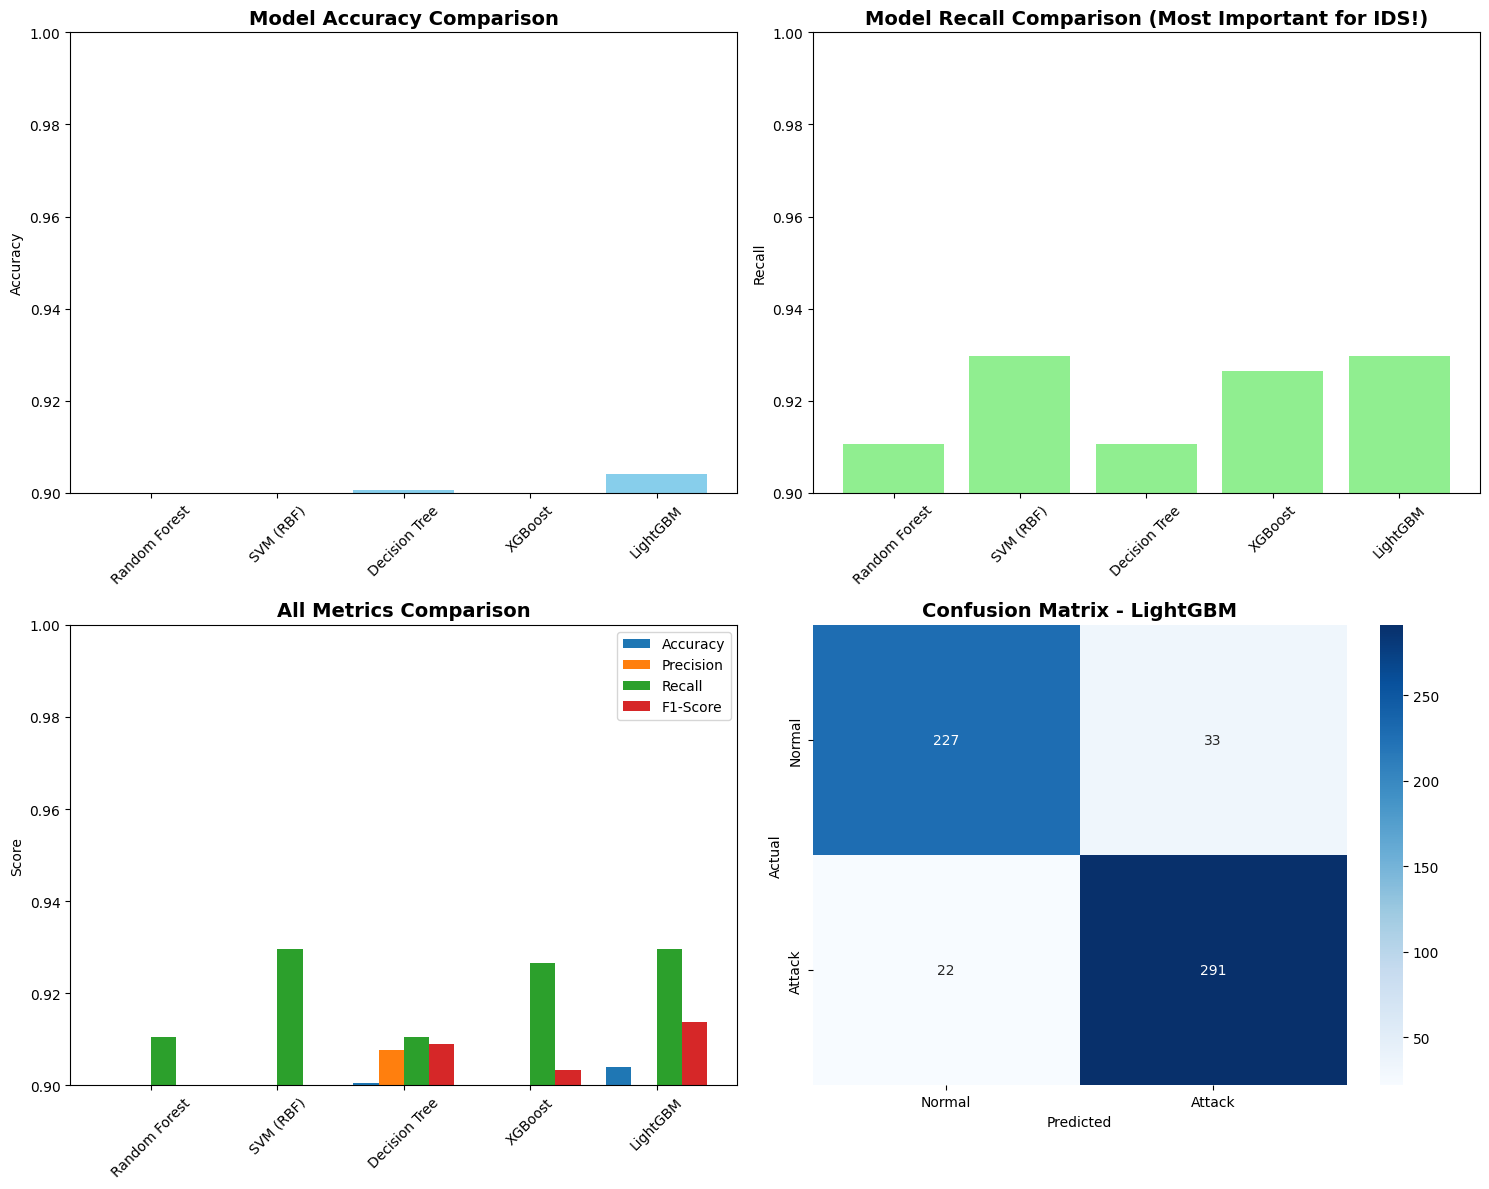

In [115]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0.9, 1.0])
axes[0, 0].tick_params(axis='x', rotation=45)

# Recall comparison (most important!)
axes[0, 1].bar(comparison_df['Model'], comparison_df['Recall'], color='lightgreen')
axes[0, 1].set_title('Model Recall Comparison (Most Important for IDS!)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_ylim([0.9, 1.0])
axes[0, 1].tick_params(axis='x', rotation=45)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[1, 0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[1, 0].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x + width * 1.5)
axes[1, 0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1, 0].legend()
axes[1, 0].set_ylim([0.9, 1.0])
cm_best = results[best_model_name]['confusion_matrix']
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'], ax=axes[1, 1])
axes[1, 1].set_title(f'Confusion Matrix - {best_model_name}', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

In [118]:
import joblib

joblib.dump(model,r'..\saved models\lgbm_telnet_ids_model.pkl')
joblib.dump(scaler,r'..\saved models\scalerlgbm.pkl')
joblib.dump(X_selected.columns.tolist(), r'..\saved models\featureslgbm.pkl')

print("Model, scaler, and features saved successfully!")

Model, scaler, and features saved successfully!


In [119]:
import joblib
import pandas as pd
import numpy as np

model = joblib.load(r'..\saved models\lgbm_telnet_ids_model.pkl')
scaler = joblib.load(r'..\saved models\scalerlgbm.pkl')
features = joblib.load(r'..\saved models\featureslgbm.pkl')

def predict_attack(sample_dict):

    df = pd.DataFrame([sample_dict])
    
    missing_features = set(features) - set(df.columns)
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")
    
    df = df[features]
    
    df = df.apply(pd.to_numeric, errors='coerce')
    
    df_scaled = scaler.transform(df)
    
    pred = model.predict(df_scaled)[0]
    prob = model.predict_proba(df_scaled)[0]
    
    return {
        "prediction": "ATTACK" if pred == 1 else "NORMAL",
        "attack_probability": float(prob[1]),
        "normal_probability": float(prob[0])
    }


sample_attack = {
    'frame.len': 138,
    'ip.proto': 6,
    'tcp.len': 72,
    'tcp.stream': 104,
    'tcp.window_size': 5888,
    'tcp_FIN': 0,
    'tcp_SYN': 0,
    'tcp_RST': 0,
    'tcp_PSH': 1,
    'tcp_ACK': 1,
    'tcp_URG': 0
}

sample_normal = {
    'frame.len': 66,
    'ip.proto': 6,
    'tcp.len': 0,
    'tcp.stream': 0,
    'tcp.window_size': 64240,
    'tcp_FIN': 0,
    'tcp_SYN': 0,
    'tcp_RST': 0,
    'tcp_PSH': 0,
    'tcp_ACK': 0,
    'tcp_URG': 0
}

print("="*50)
print("TESTING ATTACK DETECTION MODEL")
print("="*50)

print("\n1. Sample 1 (Expected: ATTACK):")
result1 = predict_attack(sample_attack)
print(f"   Prediction: {result1['prediction']}")
print(f"   Attack Probability: {result1['attack_probability']:.2%}")
print(f"   Normal Probability: {result1['normal_probability']:.2%}")

print("\n2. Sample 2 (Expected: NORMAL):")
result2 = predict_attack(sample_normal)
print(f"   Prediction: {result2['prediction']}")
print(f"   Attack Probability: {result2['attack_probability']:.2%}")
print(f"   Normal Probability: {result2['normal_probability']:.2%}")

TESTING ATTACK DETECTION MODEL

1. Sample 1 (Expected: ATTACK):
   Prediction: NORMAL
   Attack Probability: 14.98%
   Normal Probability: 85.02%

2. Sample 2 (Expected: NORMAL):
   Prediction: ATTACK
   Attack Probability: 63.23%
   Normal Probability: 36.77%
